<a href="https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/Faster_Zero_shot_Object_Detection_with_Optimum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Faster and Smaller Zero-shot Object Detection with Optimum

In this guide, we will see how to quantize and perform graph optimizations over the powerful OWL model using Optimum.

Let's start by installing `Optimum` and `ONNXRuntime` for GPU.

In [ ]:
!pip install -q optimum onnxruntime-gpu onnx

We will run `notebook_login()` to login to Hugging Face Hub. This way, we can push and pull our ONNX model and quantized/optimized models.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Load the Model and Benchmark

We will use the [fine-tuned OWLv2](https://huggingface.co/google/owlv2-large-patch14-ensemble) model. This model is known to perform better on fine-tuned classes.


Let's benchmark the PyTorch model first in different precisions and see how the model performs in them. Then we will export the model, quantize and compare the performance.

In [83]:
import requests
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, Owlv2ForObjectDetection

processor = AutoProcessor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["cat", "dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")

Get to benchmark. Note that I'm doing CPU inference here for those who don't have an A100 to test this.

In [84]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 30
timings=np.zeros((repetitions,1))

# warmup
for _ in range(10):
    _ = model(**inputs)

# measure
with torch.no_grad():
    for rep in range(repetitions):
      torch.cuda.synchronize()
      starter.record()
      _ = model(**inputs)
      ender.record()
      torch.cuda.synchronize()
      curr_time = starter.elapsed_time(ender)
      timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
print(mean_syn)

5336.438460286458


Now let's see an actual model output and how it looks like.

In [6]:
with torch.no_grad():
  outputs = model(**inputs)

target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs=outputs, threshold=0.2, target_sizes=target_sizes
)

i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


Detected cat with confidence 0.604 at location [341.66, 23.39, 642.31, 371.35]
Detected cat with confidence 0.676 at location [6.75, 51.96, 326.61, 473.14]


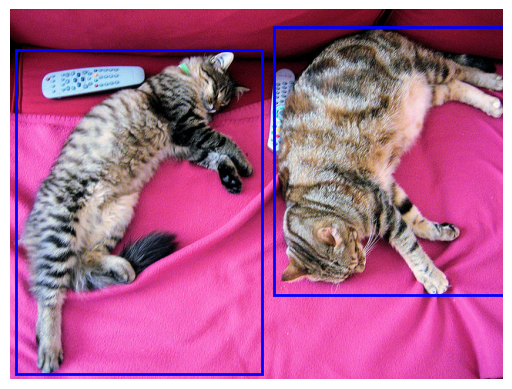

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(image)

for box, score, label in zip(boxes, scores, labels):
  box = [round(i) for i in box.tolist()]
  rectangle = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
  ax.add_patch(rectangle)

ax.axis("off")
plt.show()

In [8]:
# free up some space
del model

## Export to ONNX

We will export the loaded model and the processor to ONNX format and save them under another directory. Make sure to define the batch size as exported model expects the data to always be in certain shape.


**Note**: When exporting to ONNX, the tracing warnings we'll for the assertions are not important. If you're exporting any other model and see a tracing error with a variable assignment feel free to open an issue in transformers.

In [9]:
!optimum-cli export onnx --model google/owlv2-base-patch16-ensemble --task zero-shot-object-detection --batch_size 1 owlv2

2024-06-08 15:01:49.164084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 15:01:49.164138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 15:01:49.165565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 15:01:50.215573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Framework not specified. Using pt to export the model.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resum

## Quantize

We can now quantize the model using Optimum.

In [23]:
from optimum.onnxruntime.configuration import AutoQuantizationConfig, ORTConfig
from optimum.onnxruntime.quantization import ORTQuantizer

save_dir = "quantized_model/"

quantizer = ORTQuantizer.from_pretrained("/content/owlv2/", file_name="model.onnx")

qconfig = AutoQuantizationConfig.avx512_vnni(is_static=False)
qconfig.operators_to_quantize=['MatMul', 'Attention']
quantizer.quantize(save_dir=save_dir, quantization_config=qconfig)

Creating dynamic quantizer: QOperator (mode: IntegerOps, schema: u8/s8, channel-wise: True)
Quantizing model...
Saving quantized model at: quantized_model (external data format: False)
Configuration saved in quantized_model/ort_config.json


PosixPath('quantized_model')

## Benchmark Quantized Model

Time for a benchmark. First let's see file sizes of quantized model vs original model. There's a significant reduction.

In [59]:
!ls -h -l /content/quantized_model/model_quantized.onnx

-rw-r--r-- 1 root root 231M Jun  8 15:32 /content/quantized_model/model_quantized.onnx


In [60]:
!ls -h -l /content/owlv2/model.onnx

-rw-r--r-- 1 root root 586M Jun  8 15:02 /content/owlv2/model.onnx


We will now check how the model performs. **Note that some degradation in IoU is expected since we reduced the model to half and we are pushing model outputs to be conservative with taking the highest score.**

One should optimize the confidence filtering when working with quantized models (one could just stack the first three confident results and take the widest boundaries for instance).

In [24]:
from transformers import AutoProcessor
from PIL import Image
import onnxruntime as ort

checkpoint = "google/owlv2-base-patch16-ensemble"
processor = AutoProcessor.from_pretrained(checkpoint)

image = Image.fromarray(np.uint8(image)).convert("RGB")
text_queries = ["cat", "dog"]

np_inputs = processor(text=text_queries, images=image, return_tensors="np")
session = ort.InferenceSession("/content/quantized_model/model_quantized.onnx", providers=['CUDAExecutionProvider'])

np_inputs = dict(np_inputs)
out = session.run(['logits', 'pred_boxes', 'text_embeds', 'image_embeds'], np_inputs)

out is a list of 4 elements, decoupled into two elements where first one is logits and second one is box predictions for each predicted element.

We need to create a dummy object to handle the outputs.

In [53]:
from dataclasses import dataclass

@dataclass
class OwlOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

owl_out_1 = OwlOutput(logits = torch.from_numpy(out[0]).to("cuda"),
                        pred_boxes = torch.from_numpy(out[1]).to("cuda"))

In [71]:
target_sizes = [[max(np.array(image).shape[:2]), max(np.array(image).shape[:2])]]


In [72]:
results = processor.post_process_object_detection(owl_out_1,
                                                  threshold=0.6,
                                                  target_sizes=target_sizes)[0]

In [73]:
results["boxes"]

tensor([[349.1913,  22.9248, 623.8481, 327.1358]], device='cuda:0')

We will get the most confident output which can exclude certain pixels.

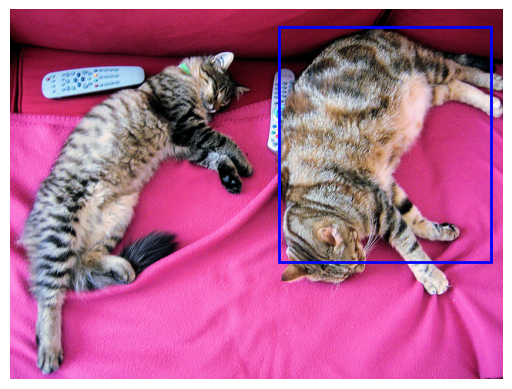

In [74]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(image)

box = [round(i) for i in results["boxes"][1].tolist()]
rectangle = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rectangle)

ax.axis("off")
plt.show()

We will check the latency of the quantized model.

In [ ]:
import time

runtimes = []

for _ in range(30):
    start = time.time()

    _ = session.run(['logits', 'pred_boxes', 'text_embeds', 'image_embeds'], np_inputs)
    end = time.time()
    runtimes.append(end-start)

Compared to 5336 ms it's quite an improvement.

In [85]:
print(f"{sum(runtimes)/len(runtimes)}")

2.864328710238139
